In [1]:
from pathlib import Path
import shutil
from tqdm import tqdm
import os

In [2]:
image_dir = "/workspaces/codespaces-jupyter/data/archive/images"
anno_dir = "/workspaces/codespaces-jupyter/data/archive/annotations"

In [3]:
path_annotations = []
for i in Path(anno_dir).glob('*.xml'):
    path_annotations.append(i)
# path_annotations = sorted(path_annotations) 

In [4]:
def extract_serial_number(file_path):
    file_name = file_path.stem  # Get the file name without extension
    serial_number = int(''.join(filter(str.isdigit, file_name)))  # Extract numerical part
    return serial_number

# Sort the file paths based on the serial number


In [5]:
path_images = []
for i in Path(image_dir).glob('*.png'):
    print(i)
    path_images.append(i)
# path_images = sorted(path_images)

/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers1505.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers950.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers1889.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers3714.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers2448.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers4505.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers3397.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers2414.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers1865.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers4346.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers3248.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers273.png
/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers3969.png
/workspaces/co

In [6]:
path_annotations = sorted(path_annotations, key=extract_serial_number)
path_images = sorted(path_images, key=extract_serial_number)

In [7]:
path_train_annot = path_annotations[:4000]
path_train_images = path_images[:4000]

path_val_annot = path_annotations[4000:4500]
path_val_images = path_images[4000:4500]

path_test_annot = path_annotations[4500:5000]
path_test_images = path_images[4500:5000]

In [8]:
os.makedirs('/workspaces/codespaces-jupyter/data/archive/train/images', exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/train/annotations',exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/val/annotations', exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/val/images', exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/test/annotations', exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/test/images', exist_ok = True)
os.makedirs('/workspaces/codespaces-jupyter/data/archive/savedmodel', exist_ok = True)

In [60]:
for i, (path_annot, path_img) in tqdm(enumerate(zip(path_train_annot, path_train_images))):
    shutil.copy(path_img, '/workspaces/codespaces-jupyter/data/archive/train/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/workspaces/codespaces-jupyter/data/archive/train/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_val_annot, path_val_images))):
    shutil.copy(path_img, '/workspaces/codespaces-jupyter/data/archive/val/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/workspaces/codespaces-jupyter/data/archive/val/annotations/' + path_annot.parts[-1])

for i, (path_annot, path_img) in tqdm(enumerate(zip(path_test_annot, path_test_images))):
    shutil.copy(path_img, '/workspaces/codespaces-jupyter/data/archive/test/images/' + path_img.parts[-1])
    shutil.copy(path_annot, '/workspaces/codespaces-jupyter/data/archive/test/annotations/' + path_annot.parts[-1])

4000it [00:02, 1481.30it/s]
500it [00:00, 1409.86it/s]
500it [00:00, 1344.87it/s]


In [9]:
import torch
from pathlib import Path
import shutil
from tqdm import tqdm
import os

BATCH_SIZE = 8 #increase / decrease according to memory
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 2
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = '/workspaces/codespaces-jupyter/data/archive/train'
# validation images and XML files directory
VALID_DIR = '/workspaces/codespaces-jupyter/data/archive/val'

TEST_DIR = '/workspaces/codespaces-jupyter/data/archive/test'

# classes: 0 index is reserved for background
CLASS_NAME = ['__background__', 'helmet', 'head', 'person']
NUM_CLASSES = len(CLASS_NAME)

In [10]:
# Apply transform to image
import albumentations as A #new method, customizable transformations
from albumentations.pytorch import ToTensorV2

# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Resize(415,415),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']}
    )

# define the validation transforms (validation data shud not be augmented)
def get_valid_transform():
    return A.Compose([
        A.Resize(415,415),
        ToTensorV2(p=1.0),
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

# The collate_fn() will help us take care of tensors of varying sizes while creating
# the training and validation data loaders.
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [11]:
# Prepare the pytorch dataset
from torch.utils.data import Dataset, DataLoader
import glob, matplotlib.pyplot as plt, matplotlib.patches as patches
import xml.etree.ElementTree as ET
from pathlib import Path

# foll is the class to create pytorch dataset from images(.png) & annotations(.xml)
class SafetyHelmDataset(Dataset):
    def __init__(self, dir_path, class_name, transforms=None):
        self.dir_path = dir_path
        self.class_name = class_name
        self.transforms = transforms
    

        # get all the image paths in sorted order
        self.image_paths = glob.glob(f"{self.dir_path}/images/*.png")
        self.all_images = sorted(self.image_paths)

    def __file_names__(self,idx:int):
        image_name = self.all_images[idx]
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')
        return image_name, annot_filepath

    def parse_xml_file(self, xml_file):
        try:
            # Parse the XML file
            tree = ET.parse(xml_file)
            root = tree.getroot()

            boxes = []
            labels = []

            # Define class to index mapping
            class_to_index = {class_label: index for index, class_label in enumerate(self.class_name)}

            # Extract bounding box coordinates and class labels from each object
            for object_element in root.findall('object'):
                # Extract class label
                class_label = object_element.find('name').text
                label_index = class_to_index.get(class_label)
                if label_index is not None:
                    labels.append(label_index)

                    # Extract bounding box coordinates
                    bbox = object_element.find('bndbox')
                    xmin = int(bbox.find('xmin').text)
                    ymin = int(bbox.find('ymin').text)
                    xmax = int(bbox.find('xmax').text)
                    ymax = int(bbox.find('ymax').text)

                    boxes.append([xmin, ymin, xmax, ymax])

            return boxes, labels
        except ET.ParseError as e:
            print(f"Error parsing XML file: {xml_file}")
            return None, None



    def __getitem__(self, idx: int):
        image_name = self.all_images[idx] #reading image one by one

        image = plt.imread(image_name) #read the image
        image /= 255.0 #normalize pixels b/w 0 & 1

        # capture the corresponding xml file for getting annotations
        annot_filepath = os.path.join(f'{self.dir_path}/annotations/', Path(image_name).parts[-1][:-4] + '.xml')

        boxes, labels = self.parse_xml_file(annot_filepath)
        # root = ET.parse(annot_filepath).getroot() #reading xml file

        # # extracting box coordinates from xml annotations
        # for member in root.findall('object'):
        #     # map the current object name to classes to get the label index
        #     labels.append(self.class_name.index(member.find('name').text))

        #     # (xmin, ymin) are left corner coordinates & (xmax, ymax) are right corner coordinates
        #     xmin = int(member.find('bndbox').find('xmin').text)
        #     ymin = int(member.find('bndbox').find('ymin').text)
        #     xmax = int(member.find('bndbox').find('xmax').text)
        #     ymax = int(member.find('bndbox').find('ymax').text)

        #     boxes.append([xmin, ymin, xmax, ymax])

        # # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # # labels to tensor
        class_to_index = {class_label: index for index, class_label in enumerate(self.class_name)}
        # class_label = member.find('name').text
        # labels.append(class_to_index[class_label])
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels 
        image_id = torch.tensor([idx])
        target['image_id'] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(image=image, bboxes=target['boxes'], labels=labels)
            image = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return image, target #these are the o/p of this class


    def __len__(self):
        return len(self.all_images)

In [12]:
train_dataset = SafetyHelmDataset(TRAIN_DIR, CLASS_NAME, get_train_transform())
valid_dataset = SafetyHelmDataset(VALID_DIR, CLASS_NAME, get_valid_transform())
test_dataset = SafetyHelmDataset(TEST_DIR, CLASS_NAME, get_valid_transform())

In [13]:
train_dataset.__getitem__(2815)

(tensor([[[0.0020, 0.0021, 0.0021,  ..., 0.0007, 0.0007, 0.0007],
          [0.0020, 0.0020, 0.0021,  ..., 0.0006, 0.0006, 0.0007],
          [0.0020, 0.0020, 0.0019,  ..., 0.0006, 0.0006, 0.0007],
          ...,
          [0.0038, 0.0038, 0.0038,  ..., 0.0038, 0.0037, 0.0037],
          [0.0037, 0.0038, 0.0038,  ..., 0.0037, 0.0037, 0.0036],
          [0.0036, 0.0036, 0.0037,  ..., 0.0036, 0.0036, 0.0036]],
 
         [[0.0024, 0.0025, 0.0025,  ..., 0.0010, 0.0010, 0.0010],
          [0.0024, 0.0024, 0.0025,  ..., 0.0009, 0.0010, 0.0010],
          [0.0024, 0.0024, 0.0023,  ..., 0.0009, 0.0009, 0.0010],
          ...,
          [0.0036, 0.0036, 0.0036,  ..., 0.0036, 0.0036, 0.0035],
          [0.0035, 0.0036, 0.0036,  ..., 0.0036, 0.0035, 0.0034],
          [0.0034, 0.0034, 0.0035,  ..., 0.0035, 0.0034, 0.0034]],
 
         [[0.0019, 0.0019, 0.0020,  ..., 0.0011, 0.0011, 0.0011],
          [0.0019, 0.0019, 0.0020,  ..., 0.0010, 0.0011, 0.0011],
          [0.0020, 0.0019, 0.0019,  ...,

In [16]:
def print_label_distribution(dataset):
    label_counts = {class_name: 0 for class_name in CLASS_NAME}  # Initialize counts for each class
    for _, target in dataset:  # Iterate through dataset
        labels = target['labels']  # Get labels for each image
        for label in labels:  # Iterate through labels
            label_index = label.item()
            class_name = CLASS_NAME[label_index]  # Get class name corresponding to label index
            
            label_counts[class_name] += 1  # Increment count for the class
    # Print label distribution
    print("Label Distribution:")
    for class_name, count in label_counts.items():
        print(f"{class_name}: {count}")
    return label_counts

# Calculate and print label distribution for train, validation, and test datasets
train_label_distribution = print_label_distribution(train_dataset)
valid_label_distribution = print_label_distribution(valid_dataset)
test_label_distribution = print_label_distribution(test_dataset)


Label Distribution:
__background__: 0
helmet: 15169
head: 4696
person: 561
Label Distribution:
__background__: 0
helmet: 1897
head: 505
person: 91
Label Distribution:
__background__: 0
helmet: 1900
head: 584
person: 99


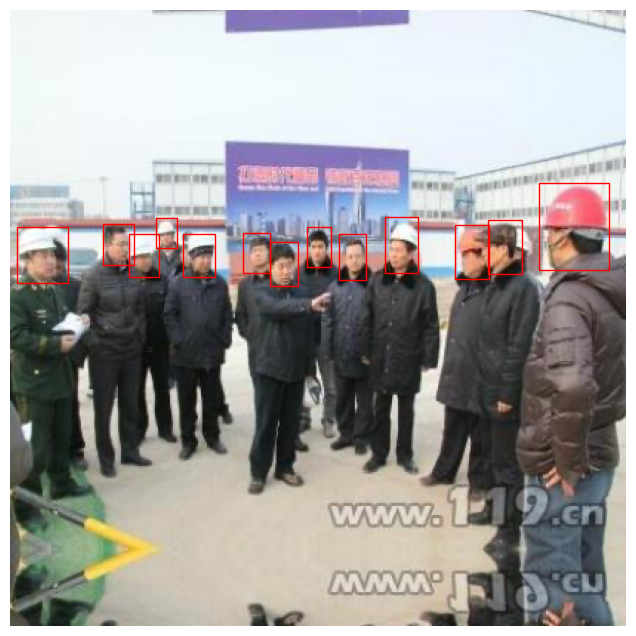

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Function to parse the annotation file and extract bounding box coordinates
import xml.etree.ElementTree as ET

def parse_annotation_file(annotation_file):
    boxes = []
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    for obj in root.findall('object'):
        # Extract class label (name) from <name> tag
        class_label = obj.find('name').text

        # Extract bounding box coordinates from <bndbox> tag
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        boxes.append((xmin, ymin, xmax, ymax))

    return boxes


# Function to plot the image with bounding boxes
def plot_image_with_boxes(image_path, annotation_path):
    # Load the image
    image = Image.open(image_path)
    
    # Parse the annotation file to get bounding box coordinates
    boxes = parse_annotation_file(annotation_path)
    
    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    
    # Draw bounding boxes
    ax = plt.gca()
    for xmin, ymin, xmax, ymax in boxes:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

# Example usage
image_path = '/workspaces/codespaces-jupyter/data/archive/images/hard_hat_workers0.png'
annotation_path = '/workspaces/codespaces-jupyter/data/archive/annotations/hard_hat_workers0.xml'
plot_image_with_boxes(image_path, annotation_path)



In [18]:
train_loader = DataLoader( #for loading data in batches, pytorch requires image as channel 1st e.g (3(channel),640(ht),480(wd))
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)


In [19]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def create_model(num_classes):
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [20]:
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)

# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# (this is the simple optimizer you can use other optimizer with callbacks for complex dataset)
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# function for running training iterations
from tqdm import tqdm


def train(train_data_loader, model):
    print('Training...')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    # criterion = torch.nn.BCELoss(size_average=True)

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad() #####
        images, targets = data #####

        images = list(image.to(DEVICE) for image in images) #####
        targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets) #####
        losses = sum(loss for loss in loss_dict.values()) #####
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward() #####
        optimizer.step() #####
        train_itr += 1 #####

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    print(losses)

    return train_loss_list

In [22]:
# The validation function returns a similar list containing the loss values
# for all the completed iterations

# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating...')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for i, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) if isinstance(v, torch.Tensor) else torch.tensor(v).to(DEVICE) for k, v in t.items()} for t in targets]


        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [23]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss

    def __call__(self, current_valid_loss, epoch, model, optimizer):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss:.3f}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/best_model.pth')


# function to save the model after each epoch and after training ends
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, '/content/drive/My Drive/helmet_dataset/savedmodel/last_model.pth')

In [24]:
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# train and validation loss lists to store loss values of all
# iterations till end and plot graphs for all iterations
train_loss_list = []
val_loss_list = []

# initialize SaveBestModel class
save_best_model = SaveBestModel()
NUM_EPOCHS = 2

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")

    # save the best model till now if we have the least loss in the current epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    # save the current epoch model
    save_model(epoch, model, optimizer)


EPOCH 1 of 2
Training...


  0%|          | 0/500 [00:01<?, ?it/s]


RuntimeError: DataLoader worker (pid 5503) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.